<a href="https://colab.research.google.com/github/jgrk/termoprojekt/blob/main/plast_klassifiering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing librarys 

import os 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
import numpy as np
import tensorflow_datasets as tfds
import PIL 
import PIL.Image
import pathlib
import matplotlib.pyplot as plt
 

In [ ]:
# Optimizing when using a GPU instead of a CPU

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# Mounting Googledrive 

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Paths to the dataset

data_dir="/content/drive/MyDrive/seven_plastics"
data_dir=pathlib.Path(data_dir)

In [ ]:
# Defining and displaying number of images

image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count)

610


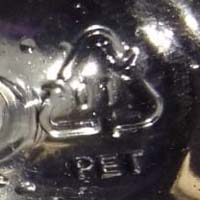

In [ ]:
# Testing the paths and ploting images

PET=list(data_dir.glob("1_polyethylene_PET/*"))
#PEHD=list(data_dir.glob("2_high_density_polyethylene_PE-HD"))
#PVC=list(data_dir.glob("3_polyvinylchloride_PVC"))
#PELD=list(data_dir.glob("4_low_density_polyethylene_PE"))
#PP=list(data_dir.glob("5_polypropylene_PP"))
#PS=list(data_dir.glob("6_polystyrene_PS"))
#blandat=list(data_dir.glob("7_other_resins"))
#icke_plast=list(data_dir.glob("8_no_plastic"))

PIL.Image.open(str(PET[0]))

In [ ]:
# Defining imagesize and batchsize

batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# Defining which images that is used for training 

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,                                    
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)



Found 610 files belonging to 7 classes.
Using 549 files for training.


In [ ]:
# Defining which images that is used for validating 

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 610 files belonging to 7 classes.
Using 61 files for validation.


In [ ]:
# Defining a variable for classnames

class_names = train_ds.class_names
print(class_names)

['1_polyethylene_PET', '2_high_density_polyethylene_PE-HD', '3_polyvinylchloride_PVC', '4_low_density_polyethylene_PE-LD', '5_polypropylene_PP', '6_polystyrene_PS', '7_other_resins']


In [ ]:
# Plotting images 

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Defining a normalization layer

normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
# Normalizing the images

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

In [ ]:
# Optimization 

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds= val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
# Defining number of classes

num_classes = len(class_names)

In [ ]:
# Test 

print(num_classes)

In [ ]:
# Building the model layer by layer

model= tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(num_classes)
])

In [ ]:
# Creating the model

model.compile(
    optimizer= "adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [ ]:
# Training the model

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    #callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]
)

In [ ]:
# Displaying the model in a summary 

model.summary()

In [ ]:
# Displays a graph with information like accuracy and loss

pd.DataFrame(history.history).plot(xlabel="epochs",ylabel="accuracy")

In [ ]:
# Predics the class of an image from directory


img_dir = "/content/drive/MyDrive/test_bilder/PS_test2.jpg"

img = tf.keras.utils.load_img(
    img_dir, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
# Saves the model in a folder
from tensorflow.keras.models import load_model
model.save(os.path.join('/content/drive/MyDrive/saved_models','plasticsmodel.h5'))